# Define the Problem

For this project, the problem statement is given to us on a golden plater, develop an algorithm to predict the survival outcome of passengers on the Titanic.
In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy. <br>
- Tools
    - It's a classic **Binary classification**. 
- Data
    - The dataset is used for this competition is synthetic but based on a real dataset (in this case, the actual [Titanic data](https://www.kaggle.com/c/titanic/data)!) and generated using a CTGAN. The statistical properties of this dataset are very similar to the original Titanic dataset, but there's no way to "cheat" by using public labels for predictions. How well does your model perform on truly private test labels?

Good luck and have fun!

# Data Load In

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-apr-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2021/train.csv
/kaggle/input/tabular-playground-series-apr-2021/test.csv


In [2]:
data_raw = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
data_val = pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')
data1 = data_raw.copy(deep=True)
data_cleaner = [data1, data_val]

Target = ['Survived']

In [3]:
for dataset in data_cleaner:
    print(dataset.info())
    print(dataset.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB
None
          PassengerId       Survived         Pclass           Name     Sex  \
count   100000.000000  100000.000000  100000.000000         100000  100000   
unique            NaN            NaN            NaN          9214

# Data Preprocessing

## Fill NA

In [4]:
for dataset in data_cleaner:
    dataset.Age.fillna(dataset.Age.median(), inplace=True)
    dataset.Embarked.fillna('S', inplace=True)
    dataset.Fare.fillna(dataset.Fare.median(), inplace=True)
    # dataset['Title'] = dataset.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    dataset['Family_members'] = dataset.Parch + dataset.SibSp

In [5]:
data1.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_members
19185,19185,0,3,"Crowder, Benjamin",male,60.0,0,0,50661,10.00,F23343,S,0
57128,57128,0,2,"Capizzi, Kenneth",male,42.0,0,0,SOTON/O2 36439,4.94,NaN,S,0
23407,23407,0,3,"Wilkins, Kevin",male,26.0,0,0,403038,8.06,NaN,S,0
24226,24226,1,1,"Cone, Pearl",female,38.0,1,0,PC 4278654,94.98,C11653,C,1
4334,4334,1,3,"Gaines, Pamela",female,68.0,0,0,PP 402664,9.81,NaN,S,0


## A Bit Visualization

Check distribution for setting bins

In [6]:
data1.drop(['Name', 'PassengerId', 'Ticket', 'SibSp', 'Parch'], axis=1, inplace=True)

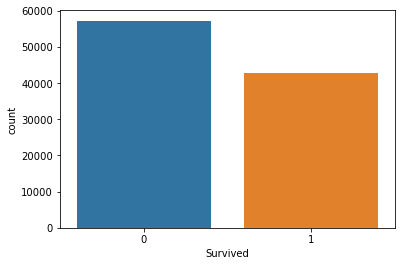

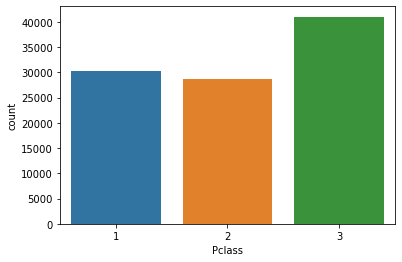

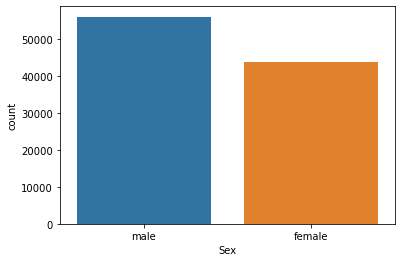

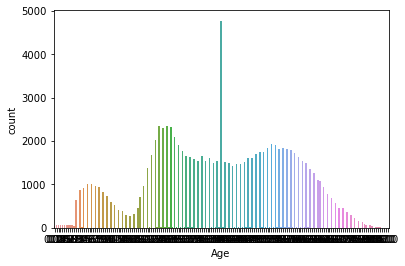

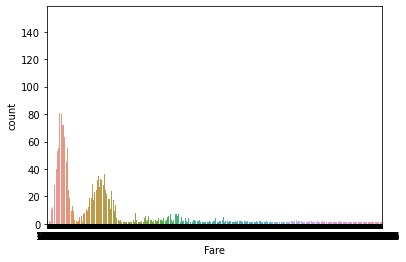

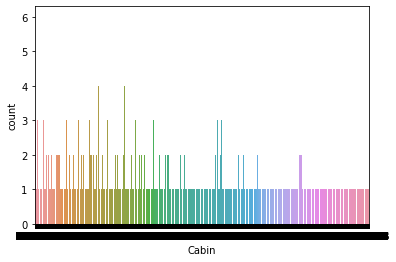

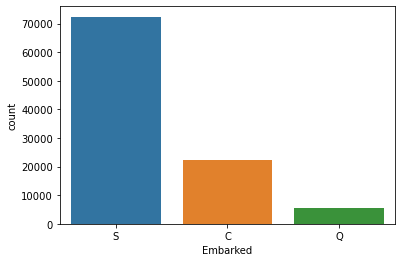

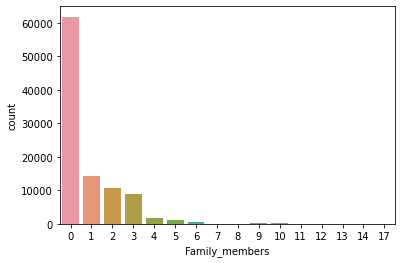

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in data1.columns:
    sns.countplot(data1[i])
    plt.show()

## Cabin

In [8]:
# data1.groupby(data1['Cabin'].isnull()).mean()
data1.groupby(data1['Cabin'].isnull())['Survived'].mean()

Cabin
False    0.608608
True     0.342101
Name: Survived, dtype: float64

In [9]:
for dataset in data_cleaner:
    dataset['Cabin_Allotted'] = np.where(dataset.Cabin.isnull(), 0, 1)
    dataset.drop('Cabin', axis=1, inplace=True)

In [10]:
data1.sample(5)
# data1['Title'].value_counts()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family_members,Cabin_Allotted
82487,0,3,female,21.0,9.91,S,0,0
19525,0,3,female,73.0,6.37,S,1,0
98213,0,3,male,37.0,9.35,C,0,0
86260,1,1,female,32.0,139.43,C,0,1
51664,0,1,male,25.0,75.34,C,0,1


## Encoder

It all goes on how you explain your feature's (X) effect on the final prediction (Y).<br>
Let's take a look at the feature `Fare`.<br>
Do you think the Fare's increment like 1 dollar would make any significant impact on their survival rate?<br>
The answer is quite obvious, right? But what if we raise the increment to i.e. 30 dollars..? Hard to tell huh!<br>
Again, it all goes on how you interpret data. In this case, I've tried them so many times. And I received the better result by *categoricalization* on `Fare` in most of them.

In [11]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

for dataset in data_cleaner:
    dataset['Sex_labeled'] = lb.fit_transform(dataset.Sex)
    
    dataset['AgeBin'] = pd.qcut(dataset.Age, 3)
    dataset['Age_labeled'] = lb.fit_transform(dataset['AgeBin'])

    dataset['FareBin'] = pd.qcut(dataset.Fare, 4)
    dataset['Fare_labeled'] = lb.fit_transform(dataset['FareBin'])

    dataset['Embarked_labeled'] = lb.fit_transform(dataset.Embarked)

In [12]:
data1.sample(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,Family_members,Cabin_Allotted,Sex_labeled,AgeBin,Age_labeled,FareBin,Fare_labeled,Embarked_labeled
4927,0,3,male,49.0,6.63,S,0,0,1,"(48.0, 87.0]",2,"(0.679, 10.04]",0,2
15443,1,1,female,71.0,30.30,Q,3,0,0,"(48.0, 87.0]",2,"(24.46, 33.47]",2,1
26729,0,1,male,57.0,87.97,S,0,1,1,"(48.0, 87.0]",2,"(33.47, 744.66]",3,2
14732,1,3,female,64.0,8.98,S,1,0,0,"(48.0, 87.0]",2,"(0.679, 10.04]",0,2
17032,0,2,male,24.0,10.42,S,0,0,1,"(0.079, 29.0]",0,"(10.04, 24.46]",1,2


In [13]:
print(data1['Age_labeled'].value_counts())
print(data1['Fare_labeled'].value_counts())

0    33875
2    33121
1    33004
Name: Age_labeled, dtype: int64
1    25040
0    25033
3    24999
2    24928
Name: Fare_labeled, dtype: int64


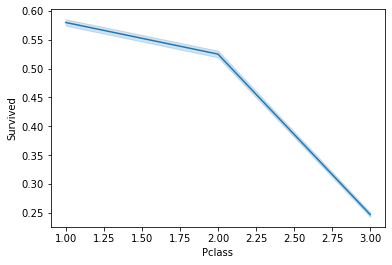

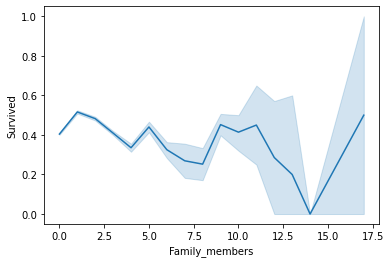

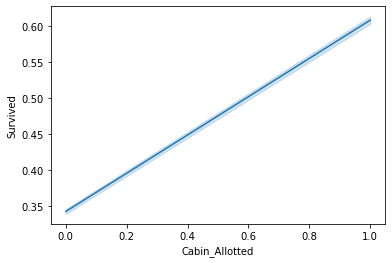

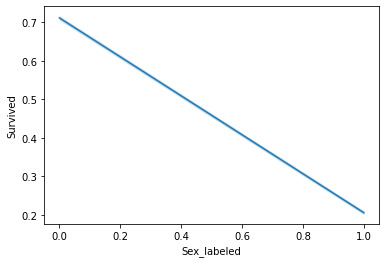

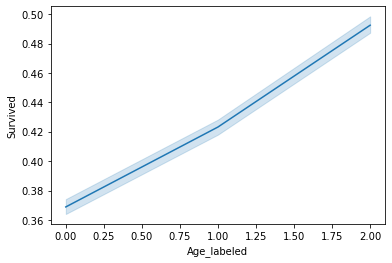

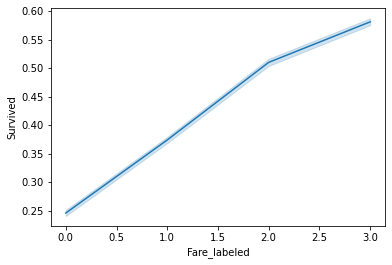

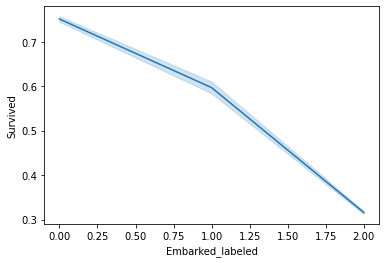

In [14]:
data1_X = [
    'Pclass', 
    'Family_members', 
    'Cabin_Allotted', 
    'Sex_labeled', 
    'Age_labeled', 
    'Fare_labeled', 
    'Embarked_labeled'
]

for i in data1[data1_X].columns:
    sns.lineplot(i, 'Survived', data=data1)
    plt.show()

In [15]:
data1[data1_X].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   Pclass            100000 non-null  int64
 1   Family_members    100000 non-null  int64
 2   Cabin_Allotted    100000 non-null  int64
 3   Sex_labeled       100000 non-null  int64
 4   Age_labeled       100000 non-null  int64
 5   Fare_labeled      100000 non-null  int64
 6   Embarked_labeled  100000 non-null  int64
dtypes: int64(7)
memory usage: 5.3 MB


# Model Selection

An easy basic way to compare different models within the same dataset.

In [16]:
from sklearn import ensemble, tree, neighbors
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import model_selection

MLA = [
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    neighbors.KNeighborsClassifier(), 

    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(), 

    XGBClassifier(objective='binary:logistic', eval_metric='logloss'),
    LGBMClassifier()
]

cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=0.2, train_size=0.8, random_state=1)

MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for alg in MLA:
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

    cv_results = model_selection.cross_validate(alg, data1[data1_X], data1[Target].values.reshape(-1,), cv=cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean() 
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3

    row_index += 1

# MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending=False, inplace=True)
MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending=False)

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
9,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",0.773282,0.77021,0.00731557,0.647807
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.769951,0.76988,0.00799606,4.17607
8,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.774784,0.769845,0.00781886,2.33663
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.76794,0.768895,0.0050741,1.69045
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.778595,0.766615,0.00788351,3.09015
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.778615,0.766385,0.00712241,2.91298
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.778075,0.7663,0.00806213,0.57209
6,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.778615,0.766255,0.00765307,0.0780266
7,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.778615,0.76607,0.00728426,0.0365568
5,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.747815,0.73735,0.0165129,3.95036


# Next: Hyperparameters

What is the importance of hyperparameter tuning? <br>
Hyperparameters are crucial as they control the overall behaviour of a machine learning model. The ultimate goal is to find an optimal combination of hyperparameters that minimizes a predefined loss function to give better results. To improve your ML skills, see [Titanic Top 11%| Starter II: Hyperparameter Tuning](https://www.kaggle.com/chienhsianghung/titanic-top-11-starter-ii-hyperparameter-tuning).<br>

Further discussion: [The Best Hyperparameters](https://www.kaggle.com/c/tabular-playground-series-apr-2021/discussion/231152)

## Tuning (Not Yet Finished)

Clearly, LightGBM received the highest grade in all models using `default hyperparameters`.<br>
In the starter Titanic challenge, using RandomForest and applying a *grid searching* technique, I can improve my score by 0.02 (from 0.76-0.78).<br> 
And now, I'm trying to use LightGBM in this competition according to my [Models Selection](https://www.kaggle.com/chienhsianghung/tps-apr-starter-pack-all-models?scriptVersionId=58964521&cellId=23) result but the `grid searching` part couldn't go well (failed in 9hrs session) because the amount of data is way too massive than the starter Titanic. It's 12GB in total.

~~So, I applied my previous [grid searching result](https://www.kaggle.com/chienhsianghung/titanic-top-11-starter-ii-hyperparameter-tuning?scriptVersionId=58924477&cellId=25) which used small Titanic data for tuning. And, it didn't improve well enough as the RandomForest does though.<br>
I still want to make a `hyperparameter searching` to see how far the LightGBM could go. Because, obviously, this's not a proper neither practicable way when we encounter a massive dataset.~~

2021 Apr. 8th update___<br>
I've tried reducing grid size, it still took me to run 27 thousand seconds and return me a *not better than RF's* improvement.

In [17]:
param = [{
    'n_estimators': [1000, 1500, 2000], # [1000, 1500, 2000, 2500]
    'max_depth':  [4, 8, 11], # [4, 5, 8, 11, -1]
    'num_leaves': [15, 31, 58, 63], # [15, 31, 58, 63, 127]
    'subsample': [0.6, 0.708, 0.8], # [0.6, 0.7, 0.708, 0.8, 1.0]
    'colsample_bytree': [0.613, 0.8, 1.0], # [0.6, 0.613, 0.7, 0.8, 1.0]
    # 'learning_rate' : [0.01, 0.02, 0.03]
}]

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
best_search = model_selection.GridSearchCV(estimator=LGBMClassifier(), param_grid=param, cv=cv_split, scoring='roc_auc')
best_search.fit(data1[data1_X], data1[Target].values.reshape(-1,))

# best_param = best_search.best_params_
# clf.set_params(**best_param)
clf = best_search.best_estimator_

print(f"Best Params:\n{str(best_search.best_params_)}")
best_search.best_score_ # Compare this with LB

Best Params:
{'colsample_bytree': 0.613, 'max_depth': 4, 'n_estimators': 1000, 'num_leaves': 31, 'subsample': 0.6}


0.8391357400205038

# Predicting

In [18]:
# after trying several times submissions, I chose RandomForestClassifier as my highest score
# model = ensemble.RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 50, 'random_state': 1})

# model = LGBMClassifier(**{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000, 'num_leaves': 15, 'subsample': 0.6})
# model.fit(data1[data1_X], data1[Target].values.reshape(-1, ))
# predictions = model.predict(data_val[data1_X])
predictions = clf.predict(data_val[data1_X])

output = pd.DataFrame({'PassengerId': data_val.PassengerId, 'Survived': predictions})
output.to_csv('./my_submission_RandomForestClassifier_tunned_F4.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## Features Importance

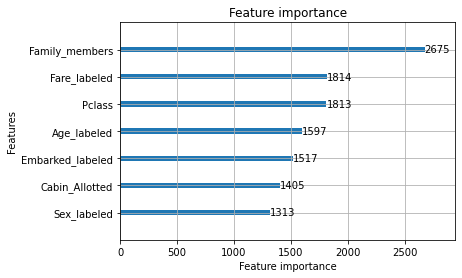

In [19]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_importance.html
from lightgbm import plot_importance

plot_importance(clf)

# References
* [A Data Science Framework: To Achieve 99% Accuracy](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy)
* [MY FIRST KAGGLE WORK TITANIC](https://www.kaggle.com/saptarshisit/my-first-kaggle-work-titanic)